In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
# env params
memorySize = 20
legalMove = 0.1
illegalMove = -0.01
outOfBounds = -0.01
memoryRepeat = -0.01
goalReached = 100

envName = 'Figure 13'
env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 9'
# env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

In [3]:
numGens = 50
maxTeamPool = 5
runs = 30
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# # init teams
# adam_and_eve = []
# env.reset()
# init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
# init_team.init_search(env, [2, 3])
# adam_and_eve.append(init_team)
# win = False
# for adam in adam_and_eve:
# #     win = adam.search(env)
#     data = [adam, win]
#     searchManager.evaluate_team(data)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [2, 3])
    adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    for gen in range(numGens):
        print(f'GEN --> {gen}')
    #     if win:
    #         print(f'got to --> gen {gen+1}')
    #         break
        toEvaluateAfterGen = []
        scores = []
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} start!>>>>>>>>>>>>>>>>>>>>>>>')
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
#                 print(f'Parent: {parent.id}')
        #             print(f'Start: {parent.start_state}')
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)
                child.id = uuid.uuid4()
                win = child.search(env)
#                 print(f'Child: {child.id}')
#                 print('Start Child Regions --------')
#                 for learner in child.learners:
#                     print(learner.program.rule.region)
#                 print('End Child Regions --------')
#                 print(f'Child Fitness: {child.fitness}') 
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
#                 print(f'Skipping Team: {parent.id}')
#                 print(parent.fitness)
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
#         print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
#         print(f'End of Gen {gen+1} Regions')
#         for i in range(len(searchManager.teamPool)):
#             print(f'Team: {i+1} --> {searchManager.teamPool[i].fitness}')
#             for learner in searchManager.teamPool[i].learners:
#                 print(learner.program.rule.region)
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} end!>>>>>>>>>>>>>>>>>>>>>>>')
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)
    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
        # end: manage fitness curves (at end of gen)
#     for team in searchManager.winners:
#         print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
#         print(team.fitness)
#         print('Learners:')
#         for learner in team.learners:
#             print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
#         print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')
    
    run_winners.append({'run': run, 'winners': searchManager.winners})

0
new step-------
3
(0, 0)
new step-------
3
(0, 0)
new step-------
2
(0, 1)
new step-------
2
(0, 2)
new step-------
2
(0, 3)
new step-------
2
(0, 4)
new step-------
2
(0, 4)
[0, 0, 0, 4]
GEN --> 0
GEN --> 1
GEN --> 2
GEN --> 3
GEN --> 4
GEN --> 5
GEN --> 6
GEN --> 7
GEN --> 8
GEN --> 9
GEN --> 10
GEN --> 11
GEN --> 12
GEN --> 13
GEN --> 14
GEN --> 15
GEN --> 16
GEN --> 17
GEN --> 18
GEN --> 19
GEN --> 20
GEN --> 21
GEN --> 22
GEN --> 23
GEN --> 24
GEN --> 25
GEN --> 26
GEN --> 27
GEN --> 28
GEN --> 29
GEN --> 30
GEN --> 31
GEN --> 32
GEN --> 33
GEN --> 34
GEN --> 35
GEN --> 36
GEN --> 37
GEN --> 38
GEN --> 39
GEN --> 40
GEN --> 41
GEN --> 42
GEN --> 43
GEN --> 44
GEN --> 45
GEN --> 46
GEN --> 47
GEN --> 48
GEN --> 49
1
new step-------
3
(0, 0)
new step-------
3
(0, 0)
new step-------
2
(0, 1)
new step-------
2
(0, 2)
new step-------
2
(0, 3)
new step-------
2
(0, 4)
new step-------
2
(0, 4)
[0, 0, 0, 4]
GEN --> 0
GEN --> 1
GEN --> 2
GEN --> 3
GEN --> 4
GEN --> 5
GEN --> 6
GEN --> 7


GEN --> 25
GEN --> 26
GEN --> 27
GEN --> 28
GEN --> 29
GEN --> 30
GEN --> 31
GEN --> 32
GEN --> 33
GEN --> 34
GEN --> 35
GEN --> 36
GEN --> 37
GEN --> 38
GEN --> 39
GEN --> 40
GEN --> 41
GEN --> 42
GEN --> 43
GEN --> 44
GEN --> 45
GEN --> 46
GEN --> 47
GEN --> 48
GEN --> 49
11
new step-------
3
(0, 0)
new step-------
3
(0, 0)
new step-------
2
(0, 1)
new step-------
2
(0, 2)
new step-------
2
(0, 3)
new step-------
2
(0, 4)
new step-------
2
(0, 4)
[0, 0, 0, 4]
GEN --> 0
GEN --> 1
GEN --> 2
GEN --> 3
GEN --> 4
GEN --> 5
GEN --> 6
GEN --> 7
GEN --> 8
GEN --> 9
GEN --> 10
GEN --> 11
GEN --> 12
GEN --> 13
GEN --> 14
GEN --> 15
GEN --> 16
GEN --> 17
GEN --> 18
GEN --> 19
GEN --> 20
GEN --> 21
GEN --> 22
GEN --> 23
GEN --> 24
GEN --> 25
GEN --> 26
GEN --> 27
GEN --> 28
GEN --> 29
GEN --> 30
GEN --> 31
GEN --> 32
GEN --> 33
GEN --> 34
GEN --> 35
GEN --> 36
GEN --> 37
GEN --> 38
GEN --> 39
GEN --> 40
GEN --> 41
GEN --> 42
GEN --> 43
GEN --> 44
GEN --> 45
GEN --> 46
GEN --> 47
GEN --> 48
GEN -

GEN --> 28
GEN --> 29
GEN --> 30
GEN --> 31
GEN --> 32
GEN --> 33
GEN --> 34
GEN --> 35
GEN --> 36
GEN --> 37
GEN --> 38
GEN --> 39
GEN --> 40
GEN --> 41
GEN --> 42
GEN --> 43
GEN --> 44
GEN --> 45
GEN --> 46
GEN --> 47
GEN --> 48
GEN --> 49
22
new step-------
3
(0, 0)
new step-------
3
(0, 0)
new step-------
2
(0, 1)
new step-------
2
(0, 2)
new step-------
2
(0, 3)
new step-------
2
(0, 4)
new step-------
2
(0, 4)
[0, 0, 0, 4]
GEN --> 0
GEN --> 1
GEN --> 2
GEN --> 3
GEN --> 4
GEN --> 5
GEN --> 6
GEN --> 7
GEN --> 8
GEN --> 9
GEN --> 10
GEN --> 11
GEN --> 12
GEN --> 13
GEN --> 14
GEN --> 15
GEN --> 16
GEN --> 17
GEN --> 18
GEN --> 19
GEN --> 20
GEN --> 21
GEN --> 22
GEN --> 23
GEN --> 24
GEN --> 25
GEN --> 26
GEN --> 27
GEN --> 28
GEN --> 29
GEN --> 30
GEN --> 31
GEN --> 32
GEN --> 33
GEN --> 34
GEN --> 35
GEN --> 36
GEN --> 37
GEN --> 38
GEN --> 39
GEN --> 40
GEN --> 41
GEN --> 42
GEN --> 43
GEN --> 44
GEN --> 45
GEN --> 46
GEN --> 47
GEN --> 48
GEN --> 49
23
new step-------
2
(0, 0)

In [4]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [5]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [6]:
for team in searchManager.winners:
    print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
    print(team.fitness)
    print('Learners:')
    for learner in team.learners:
        print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
    print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$
109.61999999999999
Learners:
Region: [0, 0, 0, 1] --> Action: [2, 3]
Region: [0, 0, 3, 4] --> Action: [2, 3]
Region: [1, 2, 1, 4] --> Action: [0, 1]
Region: [0, 0, 0, 0] --> Action: [2, 3]
Region: [0, 0, 2, 4] --> Action: [2, 3]
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [1, 0, 2, 1] --> Action: [0, 1]
Region: [0, 1, 0, 1] --> Action: [2, 3]
Region: [0, 1, 3, 2] --> Action: [2, 3]
Region: [1, 2, 0, 0] --> Action: [0, 1]
Region: [1, 2, 4, 4] --> Action: [0, 1]
Region: [0, 0, 2, 0] --> Action: [2, 3]
Region: [0, 0, 4, 4] --> Action: [2, 3]
Region: [1, 1, 0, 0] --> Action: [0, 1]
Region: [1, 1, 2, 1] --> Action: [0, 1]
Region: [0, 1, 0, 1] --> Action: [2, 3]
Region: [0, 1, 3, 2] --> Action: [2, 3]
Region: [1, 2, 0, 0] --> Action: [0, 1]
Region: [1, 2, 4, 4] --> Action: [0, 1]
Region: [0, 0, 2, 1] --> Action: [2, 3]
Region: [0, 0, 3, 4] --> Action: [2, 3]
Region: [1, 2, 0, 3] --> Action: [0, 1]
Region: [0, 4, 3, 4] --> Action: [2, 3]

## Average Max Fitness Curves

In [7]:
print(runs_score_track[0]['maxes'][49])
print(len(runs_score_track))
print(len(runs_score_track[0]))
print(len(runs_score_track[0]['maxes']))

107.47999999999999
30
4
50


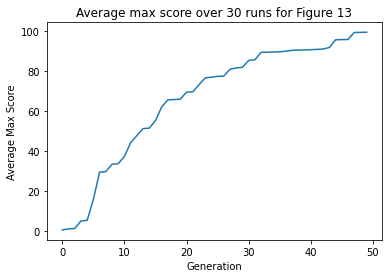

In [8]:
#fitness curves
x = []
y = []
average_maxes = np.zeros(50)

for i in range(len(gens)):
    for q in range(len(runs_score_track)):
        average_maxes[i] += runs_score_track[q]['maxes'][i]
    average_maxes[i] /= len(runs_score_track)
    
for gen in gens:
    x.append(gen)

plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
plt.xlabel('Generation')
plt.ylabel('Average Max Score')
plt.plot(x, average_maxes)
plt.show()

## Reinforcement Learning + Victory Lap

In [12]:
# team = searchManager.winners[0]
team = run_winners[0]['winners'][0]
for learner in team.learners:
    print(learner.program.rule.region)

for i in range(5):
    print(f'Epoch: {i+1} --------')
    env.reset()
    win = False
    selected_learner = team.select_learner(env)
    while not win:
        win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
        print(reward)
        if not win:
            selected_learner = team.select_learner(env)
            team.transition_update(reward, winning_action, needs_update, selected_learner)

    team.final_update(reward, winning_action, needs_update)

print(win)
for learner in team.learners:
    print(f'{learner.program.rule.region}')
    for i in range(len(learner.program.rule.action_set)):
          print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 0, 3]
[0, 4, 0, 3]
[1, 4, 2, 4]
Epoch: 1 --------
[0, 0, 0, 1]
Winning action: 2
0.1
[1, 2, 0, 3]
Winning action: 0
0.1
[0, 4, 0, 3]
Winning action: 2
0.1
[1, 4, 2, 4]
Winning action: 1
win!
100.1
Epoch: 2 --------
[0, 0, 0, 1]
Winning action: 2
0.1
[1, 2, 0, 3]
Winning action: 0
0.1
[0, 4, 0, 3]
Winning action: 2
0.1
[1, 4, 2, 4]
Winning action: 1
win!
100.1
Epoch: 3 --------
[0, 0, 0, 1]
Winning action: 2
0.1
[1, 2, 0, 3]
Winning action: 0
0.1
[0, 4, 0, 3]
Winning action: 2
0.1
[1, 4, 2, 4]
Winning action: 1
win!
100.1
Epoch: 4 --------
[0, 0, 0, 1]
Winning action: 2
0.1
[1, 2, 0, 3]
Winning action: 0
0.1
[0, 4, 0, 3]
Winning action: 2
0.1
[1, 4, 2, 4]
Winning action: 1
win!
100.1
Epoch: 5 --------
[0, 0, 0, 1]
Winning action: 2
0.1
[1, 2, 0, 3]
Winning action: 0
0.1
[0, 4, 0, 3]
Winning action: 2
0.1
[1, 4, 2, 4]
Winning action: 1
win!
100.1
True
[0, 0, 0, 1]
2 --> 100.39999999999998
3 --> 0
[0, 0, 3, 4]
2 --> 0
3 --> 0
[1, 2, 0, 3]
0 --> 100.2999999

## State Action Map (RL)

In [13]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
# print(sorted_region_action_scores)
for record in sorted_region_action_scores:
    print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'
    
    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action})

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')

# print(action_states)

{'region': [0, 0, 0, 1], 'action': 2, 'q': 100.39999999999998}
{'region': [1, 2, 0, 3], 'action': 0, 'q': 100.29999999999998}
{'region': [0, 4, 0, 3], 'action': 2, 'q': 100.19999999999999}
{'region': [1, 4, 2, 4], 'action': 1, 'q': 100.1}
{'region': [0, 0, 3, 4], 'action': 3, 'q': 0}
→ → → → ↓ 

? X ↑ X ↓ 

X X ↑ X ↓ 

? ? ↑ X X 

→ → ↑ ← ← 



## Heatmap (RL)

In [14]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

state_counts = []

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        state_count = 0
        for record in sorted_region_action_scores:
            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i

                if state == [n, m]:
                    state_count += 1
                # state count logic goes here
        state_counts.append({'state': (n, m), 'count': state_count})

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        for record in state_counts:
            if (n, m) == record['state']:
                count = record['count']
                print(f'{count} ', end='')
    print('')

1 1 1 1 1 
0 0 1 0 1 
0 0 1 0 1 
0 0 1 0 0 
1 1 1 1 1 
